In [1]:
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from surface_dice import SurfaceDiceMetric
import albumentations as A
import random
import matplotlib.cm as cm
import segmentation_models_pytorch as smp
from math import ceil
from patcher import Patcher

device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"

# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
net = smp.Unet(
    encoder_name="timm-mobilenetv3_small_075",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
net.load_state_dict(torch.load("baseline.pth"))
net.to(device)
net.eval();

In [3]:
imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"

patch_size = 224

img1_path = imgs_dir + "1028.tif"
img2_path = "1028_mod.tif"

img1 = np.array(Image.open(img1_path), dtype=np.float32)
img2 = np.array(Image.open(img2_path), dtype=np.float32)

# x1_clipped = torch.from_numpy(img1.clip(max=35000))[None, :]
x1 = torch.from_numpy(img1)[None, :]
x2 = torch.from_numpy(img2)[None, :]

x1_clipped = x1.clip(max=35000) / x1.clip(max=35000).max()
x1_x2_max = x1 / x2.max()
print("x2 max:", x2.max())
x2 /= x2.max()


x2 max: tensor(35549.)


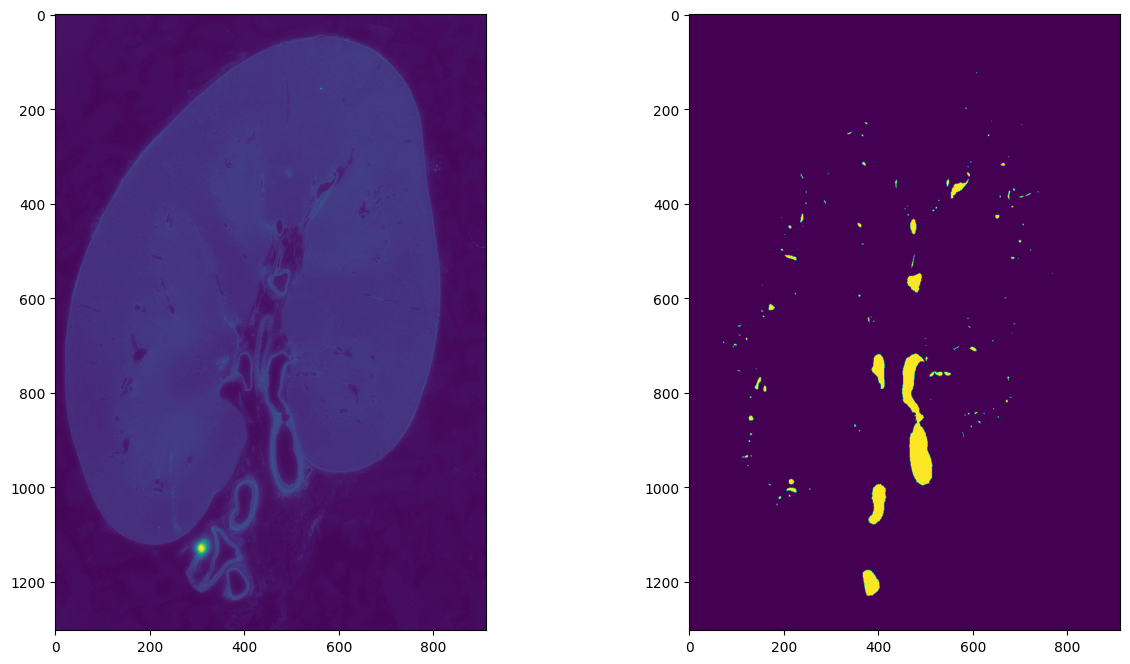

In [4]:
import cv2
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].imshow(cv2.imread(imgs_dir + "1028.tif", cv2.IMREAD_GRAYSCALE))
axs[1].imshow(cv2.imread(msks_dir + "1028.tif", cv2.IMREAD_GRAYSCALE))
plt.show()

In [5]:
h, w = img1.shape[-2:]
print(h, w)

overlap = 50
patcher = Patcher(h, w, patch_size=patch_size, overlap=overlap)

x1_clipped = patcher.extract_patches(x1_clipped)  
x1_x2_max = patcher.extract_patches(x1_x2_max)  
x2 = patcher.extract_patches(x2)  

1303 912


In [6]:
def pred(x, norm_patches=False):
    x = x.to(device)
    with torch.no_grad():
        x = x.reshape(-1, 1, patch_size, patch_size)  # (40, 1, patch_size, patch_size)
        if norm_patches:
            x /= x.max(0, keepdim=True).values
        logits = net(x) 
        logits = logits.view(1, -1, patch_size, patch_size)  
        logits = patcher.merge_patches(logits).squeeze()  # (bs, h, w)
    return logits.cpu()


In [7]:
probs1_clipped = pred(x1_clipped).sigmoid() 
probs1_x2_max = pred(x1_x2_max).sigmoid() 
probs2 = pred(x2).sigmoid()


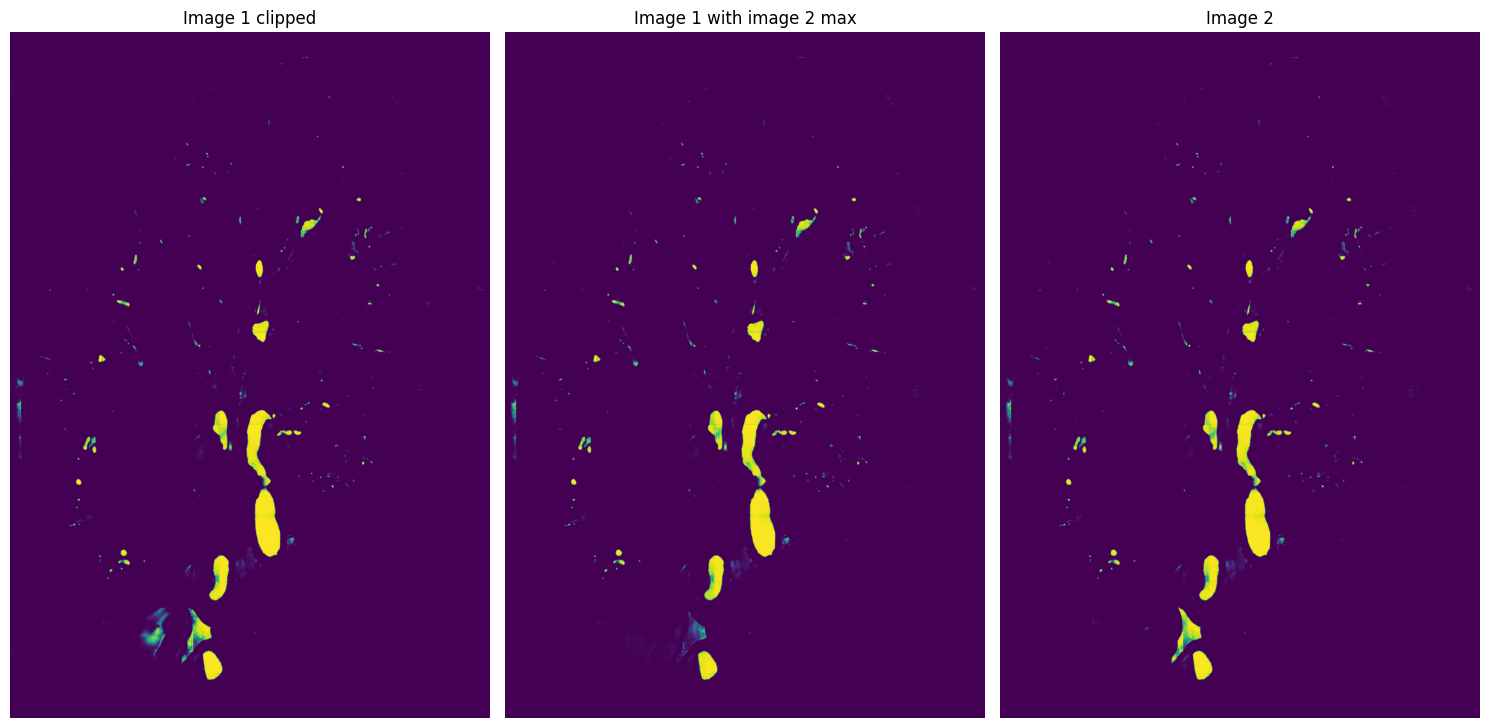

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].set_title("Image 1 clipped")
axs[0].imshow((cm.viridis(probs1_clipped) * 255).astype(np.uint8))

axs[1].set_title("Image 1 with image 2 max")
axs[1].imshow((cm.viridis(probs1_x2_max) * 255).astype(np.uint8))

axs[2].set_title("Image 2")
axs[2].imshow((cm.viridis(probs2) * 255).astype(np.uint8))
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.tight_layout()
plt.show()